In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# PROMPT: find all files matching ../out16/accuracy_*.csv, load them as dataframes and conatentate them
# PROMPT: ignore the first index column when loading the dataframes
# PROMPT: When loading the data use the filename pattern ../out16/accuracy_{dataset}_run_{runid}.csv. Include runid as a column
# PROMPT: Use good practices: match to a regex rather than hardcoding the index of runid
# (manual edits)

import pandas as pd
import glob
import re

# Define the regex pattern to match filenames
pattern = r'../out16/accuracy_(?P<datafile>.*?)_run_(?P<runid>\d+)\.csv'

# Use the glob library to find all matching files
file_list = glob.glob('../out16/accuracy_*.csv')

# Initialize an empty list to store dataframes
dfs = []

# Loop through the files, load them as dataframes, and extract dataset and runid using regex
for file in file_list:
    match = re.match(pattern, file)
    if match:
        datafile = match.group('datafile')
        runid = match.group('runid')
        
        # Load the CSV file
        df = pd.read_csv(file, index_col=0)  # Specify index_col=0 to ignore the first index column
        
        # Add the runid as a new column in the dataframe
        df['runid'] = runid
        df['datafile'] = datafile
        assert (df['dataset'] == df['datafile'] + '_run_' + df['runid']).all()
        
        # Append the dataframe to the list
        dfs.append(df)

# Concatenate all dataframes into a single dataframe
df = pd.concat(dfs, ignore_index=True)

# Now, final_df contains the concatenated data from all matching CSV files with the runid as a column


In [3]:
df

,alg,batch,acc,nodes,dataset,similarity,train-duration,test-duration,runid,datafile
0,efdt,1,0.71711,3,Susy_run_7,NaN,1.206795,1.204462,7,Susy
1,efdt,2,0.71711,3,Susy_run_7,1.000000,1.436486,1.191303,7,Susy
2,efdt,3,0.71711,3,Susy_run_7,1.000000,1.435682,1.197255,7,Susy
3,efdt,4,0.75693,5,Susy_run_7,0.724912,1.551719,1.250038,7,Susy
4,efdt,5,0.75738,7,Susy_run_7,0.979966,0.538111,1.268605,7,Susy
...,...,...,...,...,...,...,...,...,...,...
12746,tree-retrain_30_0,6,0.75804,9,Susy_run_1,0.475500,1.650448,0.409793,1,Susy
12747,tree-retrain_30_0,7,0.75468,9,Susy_run_1,0.660494,1.973085,0.443702,1,Susy
12748,tree-retrain_30_0,8,0.75545,7,Susy_run_1,0.653876,2.218930,0.405082,1,Susy
12749,tree-retrain_30_0,9,0.75725,9,Susy_run_1,0.474859,2.879189,0.438020,1,Susy


In [4]:
# PROMPT: alg follows the pattern {algoritm}_{alpha}_{beta} or just {algorithm}. Add columns for algorithm, alpha and beta. In that latter case, make alpha and beta to null
# Split 'alg' column
df['algorithm'] = df['alg'].apply(lambda x: x.split('_')[0])
df['alpha'] = df['alg'].apply(lambda x: int(x.split('_')[1]) if len(x.split('_')) > 1 else pd.NA)
df['beta'] = df['alg'].apply(lambda x: int(x.split('_')[2]) if len(x.split('_')) > 2 else pd.NA)

In [5]:
df['alg'].unique()

array(['efdt', 'vfdt', 'keep-regrow_10_1', 'tree-retrain_10_1',
       'keep-regrow_10_0', 'keep-regrow_10_2', 'keep-regrow_10_3',
       'keep-regrow_10_4', 'keep-regrow_10_5', 'keep-regrow_10_10',
       'keep-regrow_1_1', 'tree-retrain_1_0', 'keep-regrow_5_1',
       'tree-retrain_5_0', 'keep-regrow_20_1', 'tree-retrain_20_0',
       'keep-regrow_30_1', 'tree-retrain_30_0'], dtype=object)

In [6]:
# tree-retrain can be thought of as a speical case of keep-regrow where we actively discard the regrown tree

# PROMPT: if algorithm is tree-retrain add a duplicate record for algorithm is 'keep-regrow', alpha is same and beta is -1

# Find rows with 'algorithm' as 'tree-retrain'
tree_retrain_rows = df[df['algorithm'] == 'tree-retrain']

# Create duplicate rows with 'algorithm' as 'keep-regrow' and 'beta' as -100
duplicate_rows = tree_retrain_rows.copy()
duplicate_rows['alg'] = 'keep-regrow_' + duplicate_rows['alpha'].apply(str) + "_-100" 
duplicate_rows['algorithm'] = 'keep-regrow'
duplicate_rows['beta'] = -100

# Append the duplicate rows to the original dataframe
df = pd.concat([df, duplicate_rows], ignore_index=True)


In [7]:
# original tree can be thought of as a speical case of keep-regrow with very high beta

# Find rows with 'algorithm' as 'keep-regrow'
tree_retrain_rows = df[(df['algorithm'] == 'keep-regrow') & (df['batch'] == 1) & (df['beta'] == 1)]

for b in range(1, 10 + 1):
    # Create duplicate rows with 'algorithm' as 'keep-regrow' and 'beta' as 100
    duplicate_rows = tree_retrain_rows.copy()
    duplicate_rows['alg'] = 'keep-regrow_' + duplicate_rows['alpha'].apply(str) + "_100" 
    duplicate_rows['batch'] = b
    duplicate_rows['beta'] = 100
    duplicate_rows['similarity'] = 1

    # Append the duplicate rows to the original dataframe
    df = pd.concat([df, duplicate_rows], ignore_index=True)


In [8]:
df[df['beta'] == 100]

,alg,batch,acc,nodes,dataset,similarity,train-duration,test-duration,runid,datafile,algorithm,alpha,beta
16301,keep-regrow_10_100,1,0.72462,3,Susy_run_7,1.0,0.234078,0.230234,7,Susy,keep-regrow,10,100
16302,keep-regrow_1_100,1,0.73830,97,Susy_run_7,1.0,0.227015,1.139796,7,Susy,keep-regrow,1,100
16303,keep-regrow_5_100,1,0.74604,7,Susy_run_7,1.0,0.221698,0.386788,7,Susy,keep-regrow,5,100
16304,keep-regrow_20_100,1,0.72462,3,Susy_run_7,1.0,0.227071,0.235150,7,Susy,keep-regrow,20,100
16305,keep-regrow_30_100,1,0.72462,3,Susy_run_7,1.0,0.226639,0.232348,7,Susy,keep-regrow,30,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19846,keep-regrow_10_100,10,0.75701,5,Susy_run_1,1.0,0.168917,0.348615,1,Susy,keep-regrow,10,100
19847,keep-regrow_1_100,10,0.74094,87,Susy_run_1,1.0,0.168342,0.899525,1,Susy,keep-regrow,1,100
19848,keep-regrow_5_100,10,0.75701,5,Susy_run_1,1.0,0.163517,0.340486,1,Susy,keep-regrow,5,100
19849,keep-regrow_20_100,10,0.75701,5,Susy_run_1,1.0,0.168074,0.341037,1,Susy,keep-regrow,20,100


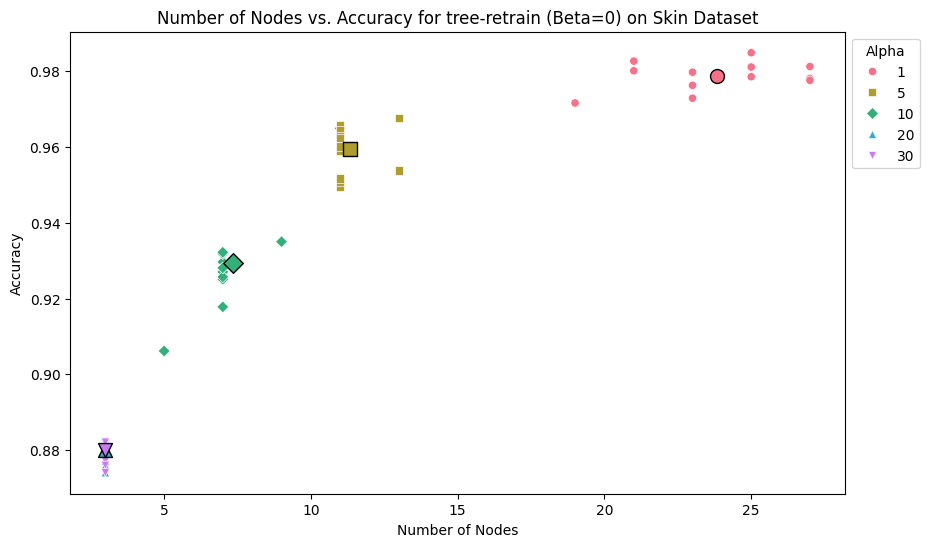

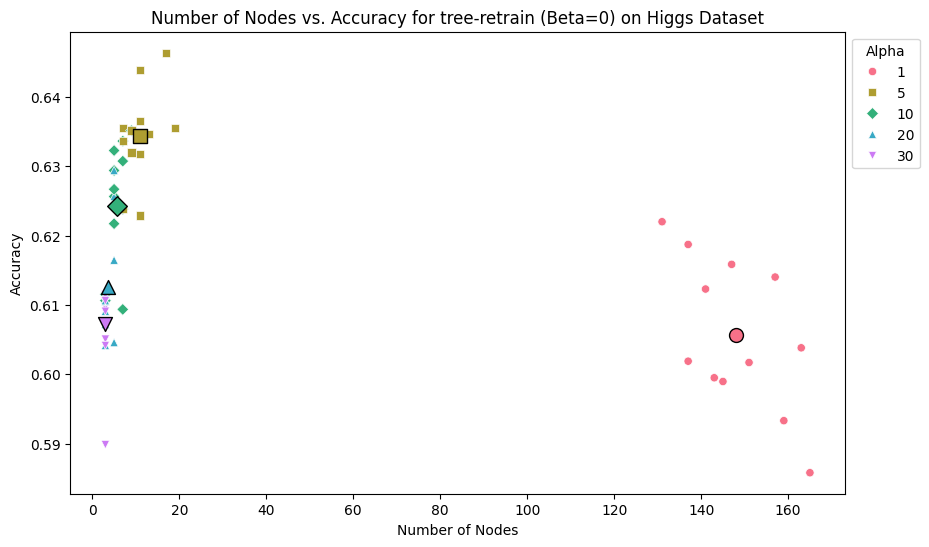

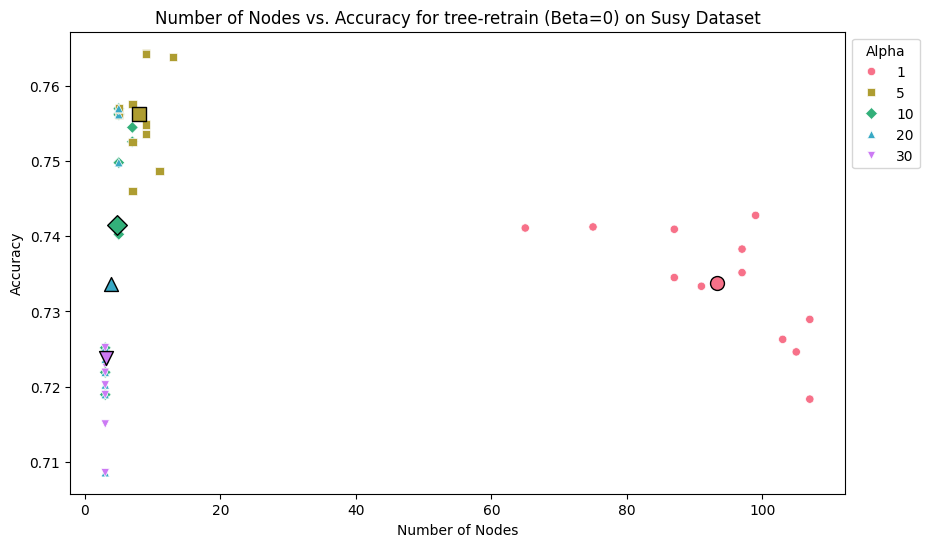

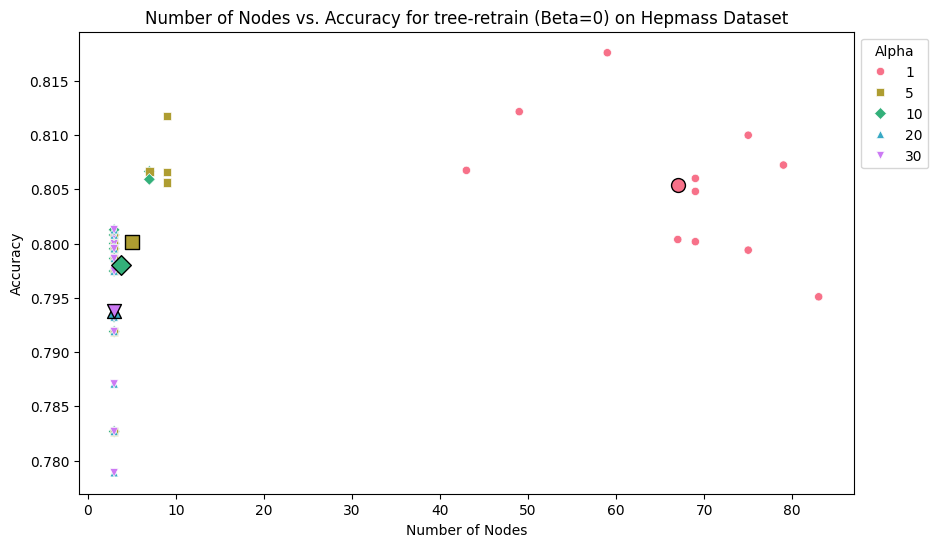

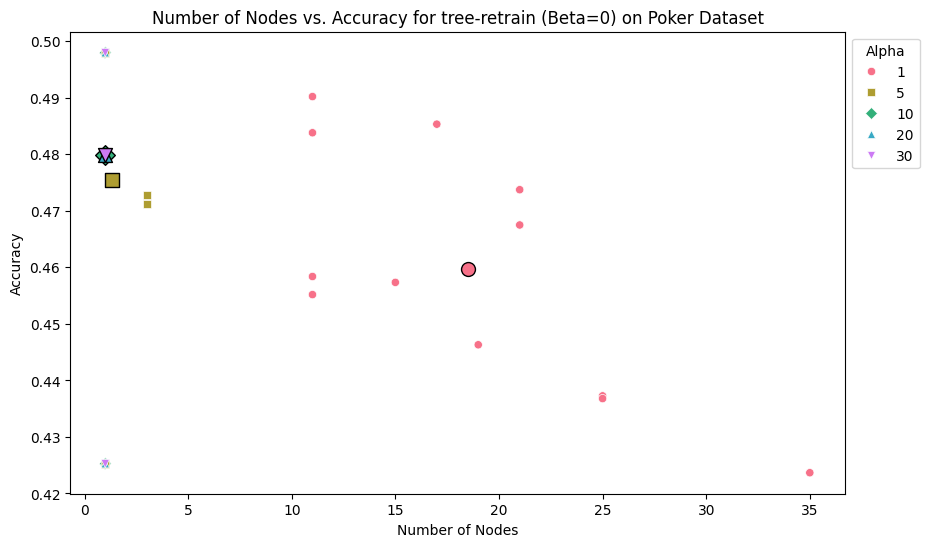

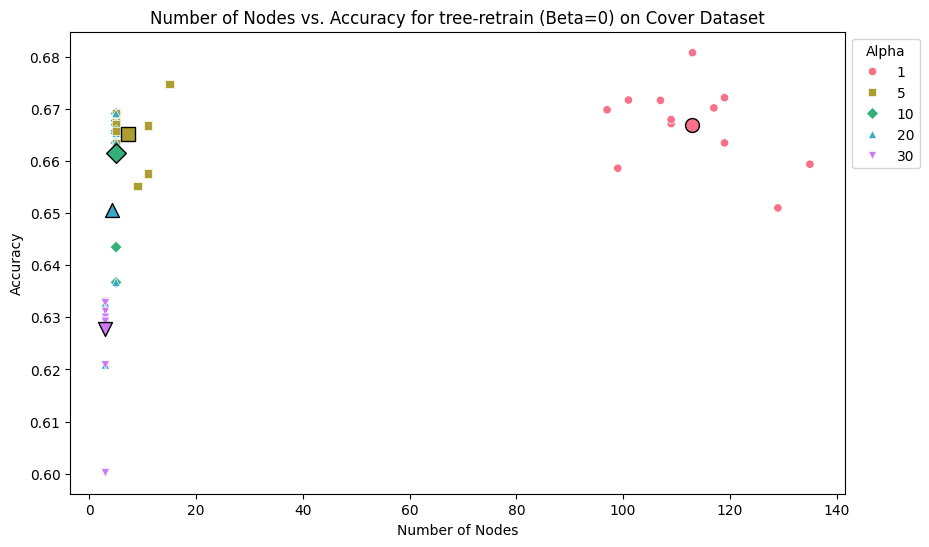

In [9]:
# Get unique datafile names
# unique_datafiles = df['datafile'].unique()
# Use the same order as generated
unique_datafiles = ['Skin', 'Higgs', 'Susy', 'Hepmass', 'Poker', 'Cover']

# Loop through each unique datafile and create a separate plot
for datafile in unique_datafiles:
    # Filter the data for the desired conditions
    filtered_df = df[(df['algorithm'] == 'tree-retrain') &
                     (df['datafile'] == datafile) &
                     #(df['beta'] == 0) & # beta ignored, so doesn't matter if 1 or 0
                     (df['batch'] == 1)
                    ]

    # Calculate the group averages
    grouped = filtered_df.groupby('alpha').agg({'acc': 'mean', 'nodes': 'mean'}).reset_index()

    # Create a custom palette with distinct colors
    custom_palette = sns.color_palette("husl", len(filtered_df['alpha'].unique()))

    # Create a custom list of markers for distinct symbols
    markers = ["o", "s", "D", "^", "v"]

    # Create the scatter plot with distinct colors and symbols
    plt.figure(figsize=(10, 6))
    sns.scatterplot(y='acc', x='nodes', hue='alpha', style='alpha', markers=markers, palette=custom_palette, data=filtered_df)
    plt.title(f'Number of Nodes vs. Accuracy for tree-retrain (Beta=0) on {datafile} Dataset')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of Nodes')
    plt.legend(title='Alpha', loc='upper left', bbox_to_anchor=(1, 1))

    # Plot the group averages as symbols
    for index, row in grouped.iterrows():
        plt.scatter(row['nodes'], row['acc'], marker=markers[index], s=100, color=custom_palette[index], edgecolor='black', linewidth=1)

    plt.show()


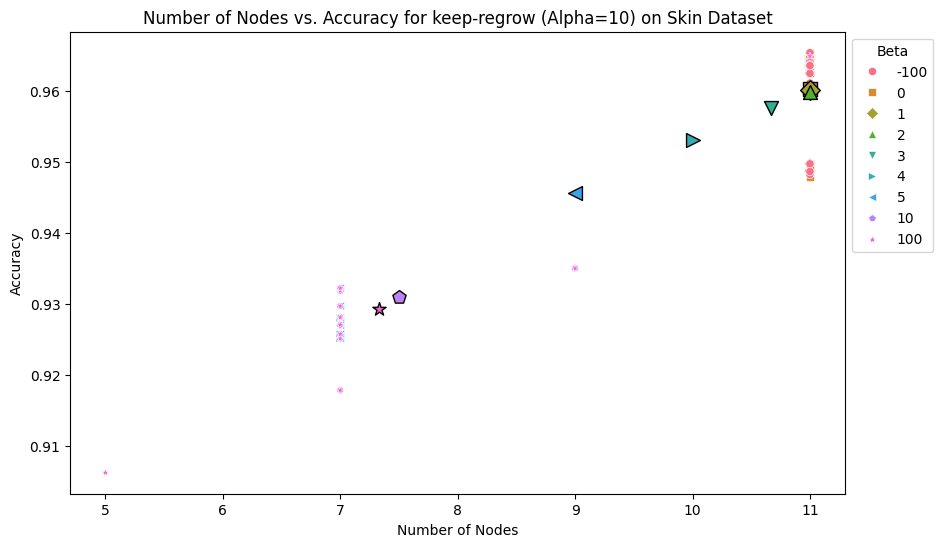

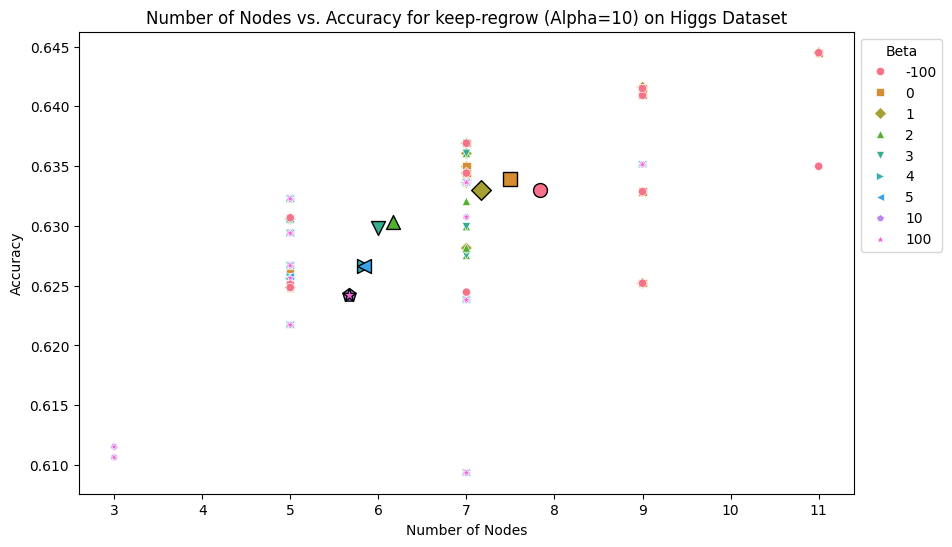

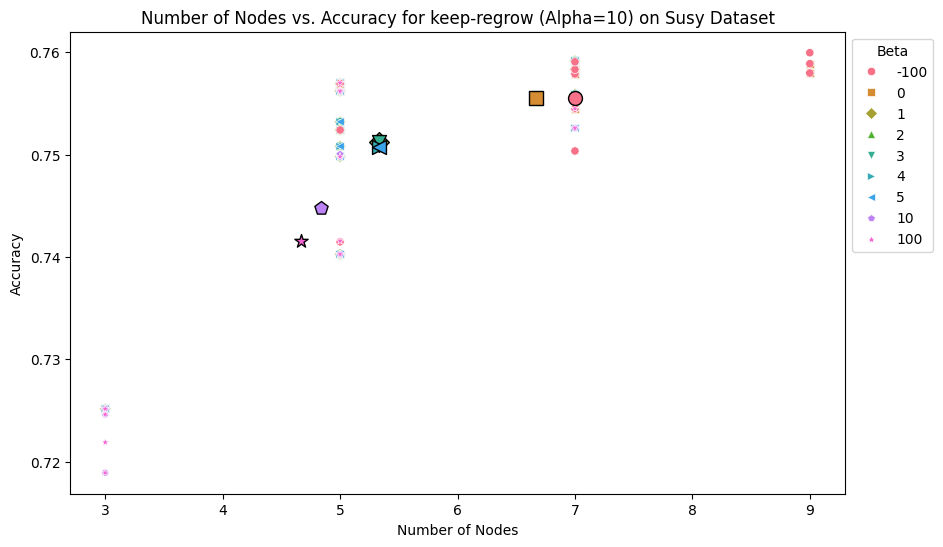

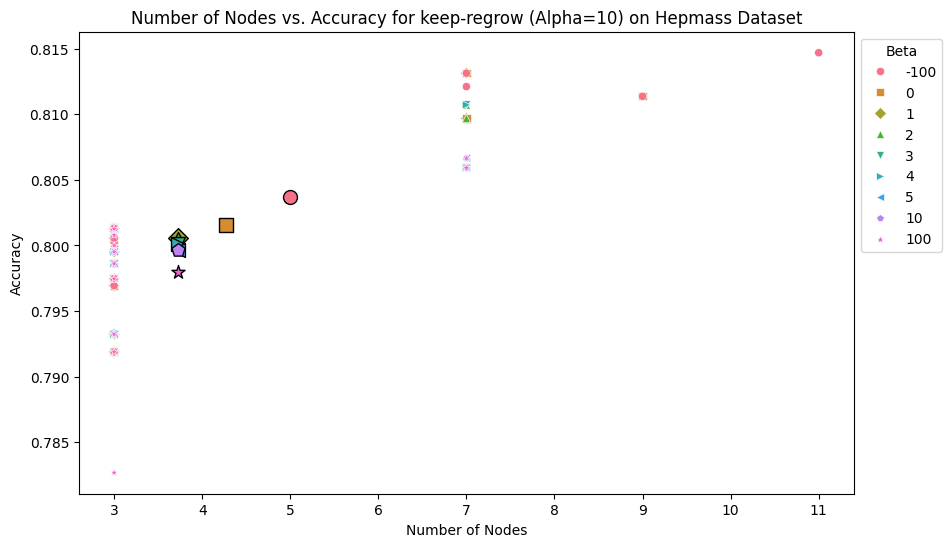

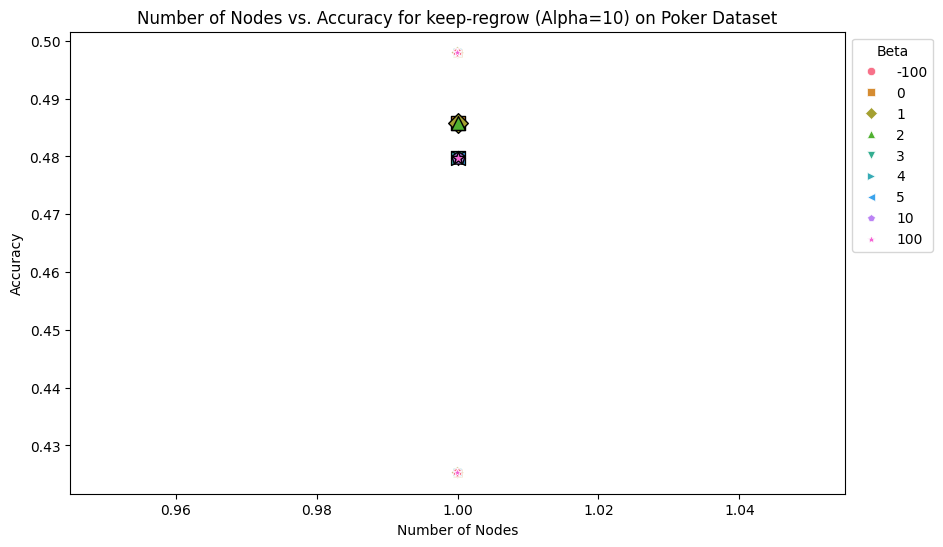

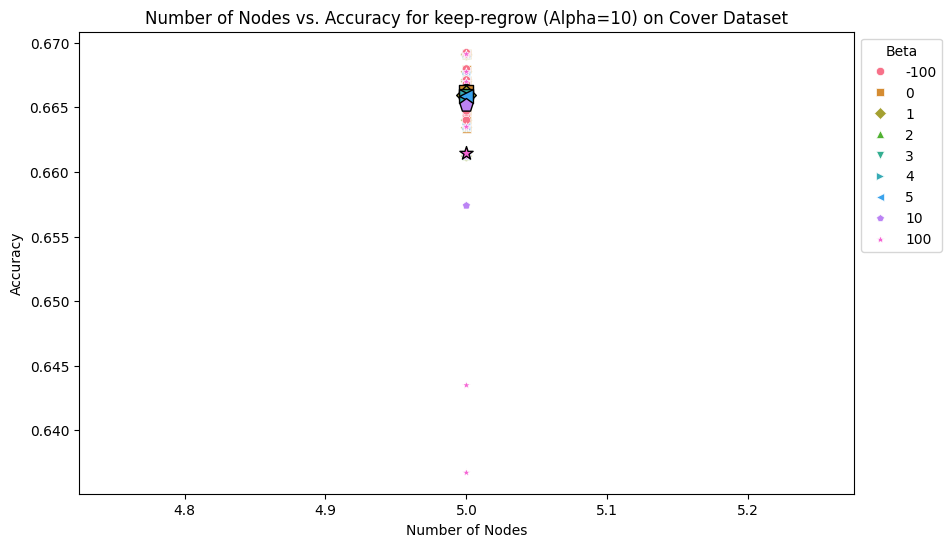

In [10]:
# Get unique datafile names
# unique_datafiles = df['datafile'].unique()
# Use the same order as generated
unique_datafiles = ['Skin', 'Higgs', 'Susy', 'Hepmass', 'Poker', 'Cover']

# Loop through each unique datafile and create a separate plot
for datafile in unique_datafiles:
    # Filter the data for the desired conditions
    filtered_df = df[(df['algorithm'] == 'keep-regrow') &
                     (df['datafile'] == datafile) &
                     (df['alpha'] == 10) &
                     (df['batch'] == 2)
                    ]

    # Calculate the group averages
    grouped = filtered_df.groupby('beta').agg({'acc': 'mean', 'nodes': 'mean'}).reset_index()

    # Create a custom palette with distinct colors
    custom_palette = sns.color_palette("husl", len(filtered_df['beta'].unique()))

    # Create a custom list of markers for distinct symbols
    markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*']
 markers = ['o', 's', 'D', '^', 'v', '>', '<']
    # Create the scatter plot with distinct colors and symbols
    plt.figure(figsize=(10, 6))
    sns.scatterplot(y='acc', x='nodes', hue='beta', style='beta', markers=markers, palette=custom_palette, data=filtered_df)
    plt.title(f'Number of Nodes vs. Accuracy for keep-regrow (Alpha=10) on {datafile} Dataset')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of Nodes')
    plt.legend(title='Beta', loc='upper left', bbox_to_anchor=(1, 1))

    # Plot the group averages as symbols
    for index, row in grouped.iterrows():
        plt.scatter(row['nodes'], row['acc'], marker=markers[index], s=100, color=custom_palette[index], edgecolor='black', linewidth=1)

    plt.show()


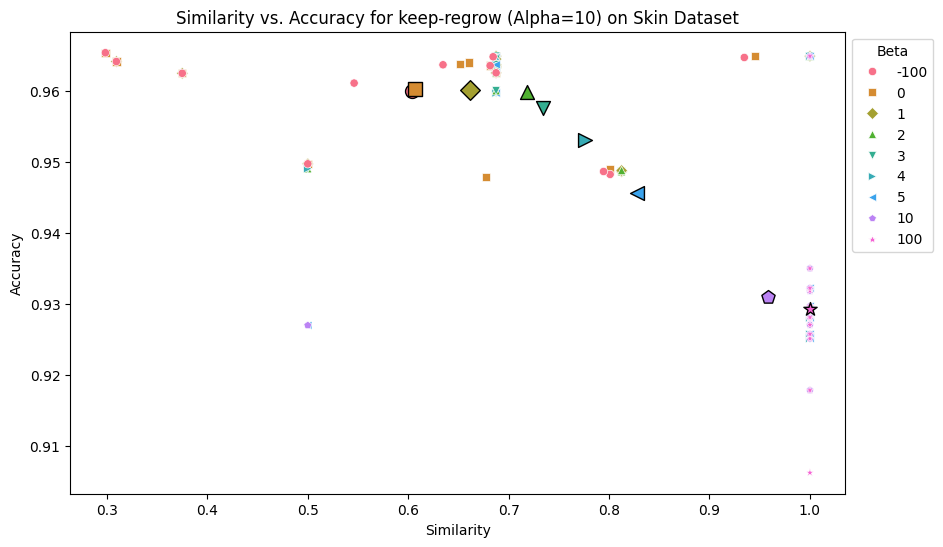

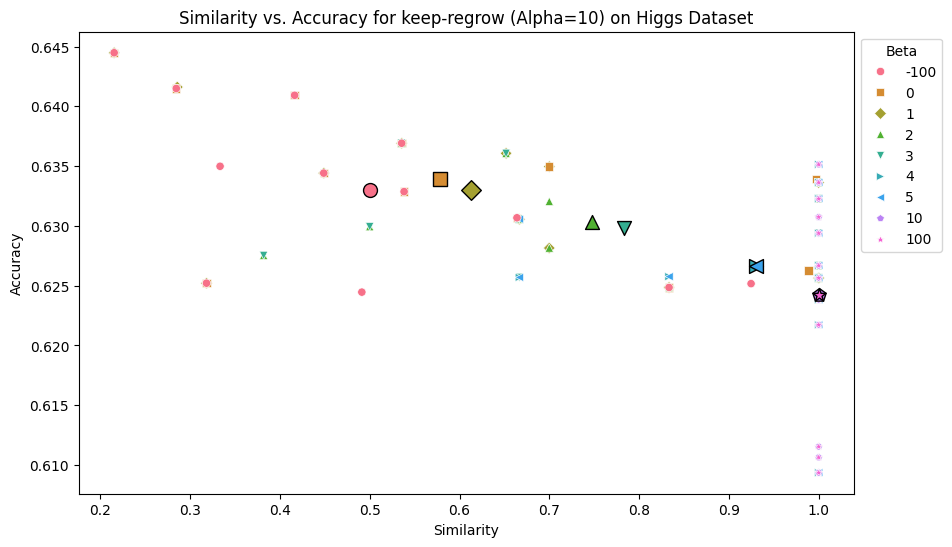

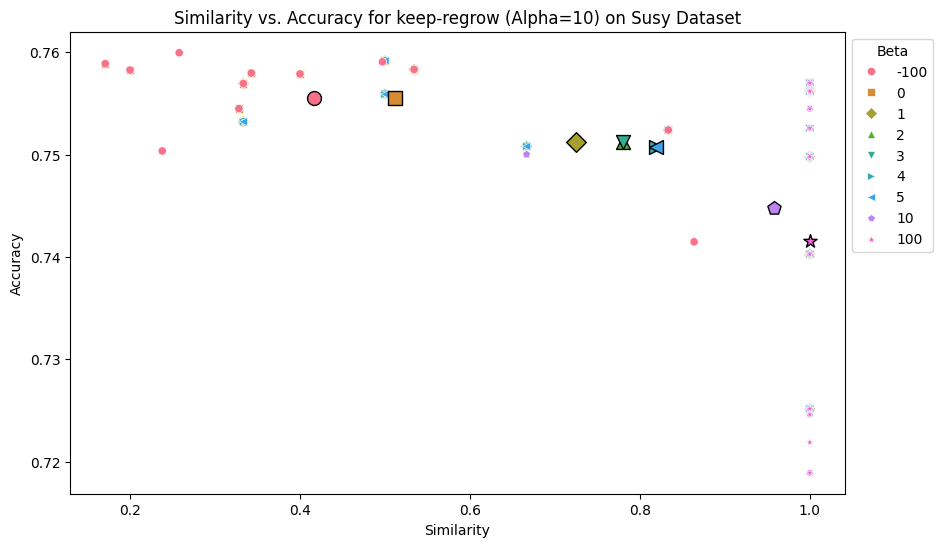

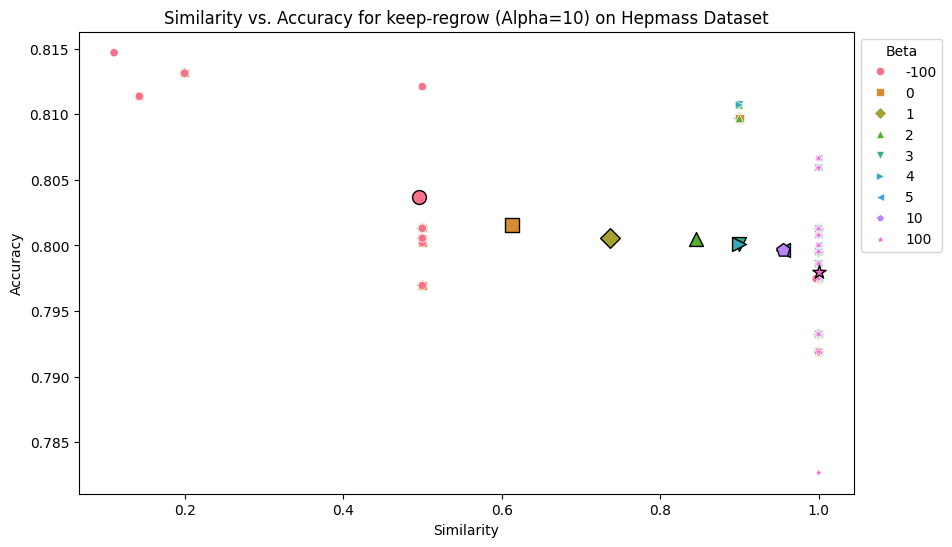

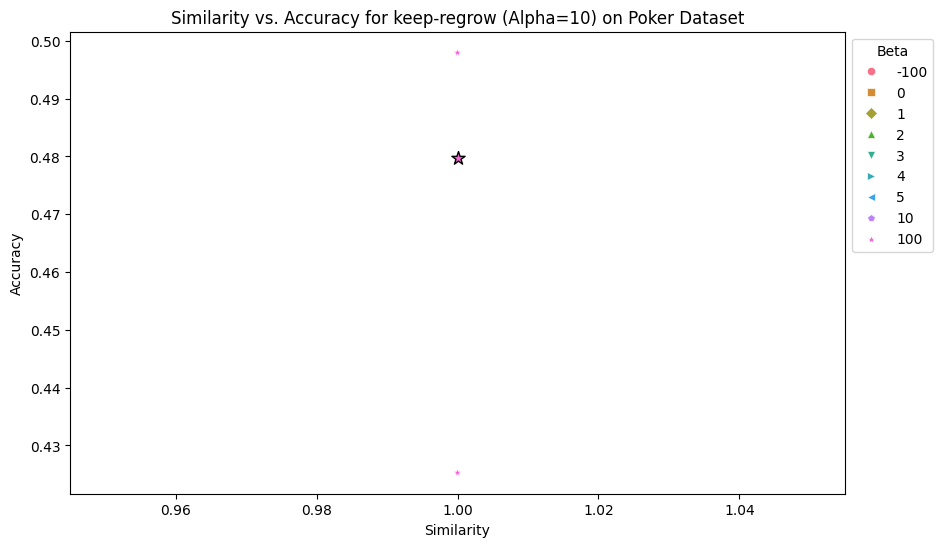

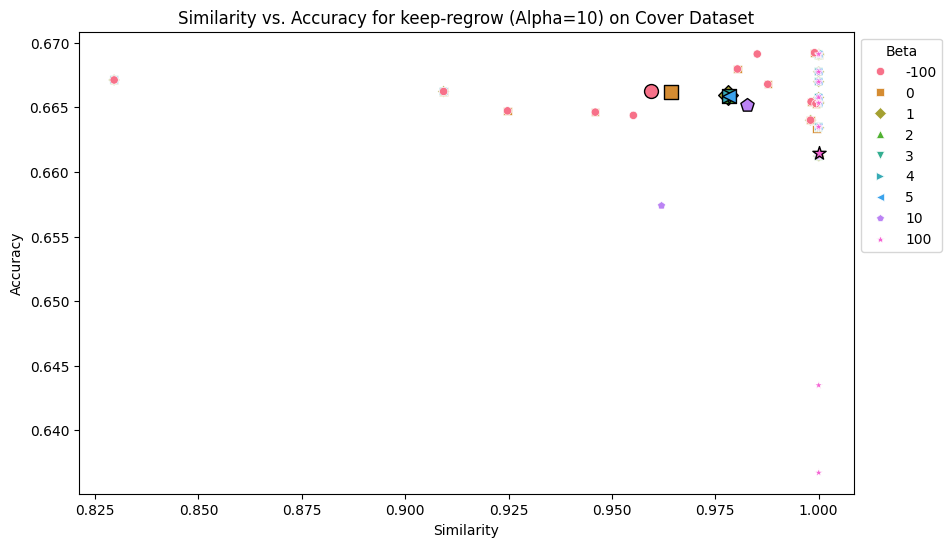

In [11]:
# Get unique datafile names
# unique_datafiles = df['datafile'].unique()
# Use the same order as generated
unique_datafiles = ['Skin', 'Higgs', 'Susy', 'Hepmass', 'Poker', 'Cover']

# Loop through each unique datafile and create a separate plot
for datafile in unique_datafiles:
    # Filter the data for the desired conditions
    filtered_df = df[(df['algorithm'] == 'keep-regrow') &
                     (df['datafile'] == datafile) &
                     (df['alpha'] == 10) &
                     (df['batch'] == 2)
                    ]

    # Calculate the group averages
    grouped = filtered_df.groupby('beta').agg({'acc': 'mean', 'similarity': 'mean'}).reset_index()

    # Create a custom palette with distinct colors
    custom_palette = sns.color_palette("husl", len(filtered_df['beta'].unique()))

    # Create a custom list of markers for distinct symbols
    markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*']

    # Create the scatter plot with distinct colors and symbols
    plt.figure(figsize=(10, 6))
    sns.scatterplot(y='acc', x='similarity', hue='beta', style='beta', markers=markers, palette=custom_palette, data=filtered_df)
    plt.title(f'Similarity vs. Accuracy for keep-regrow (Alpha=10) on {datafile} Dataset')
    plt.ylabel('Accuracy')
    plt.xlabel('Similarity')
    plt.legend(title='Beta', loc='upper left', bbox_to_anchor=(1, 1))

    # Plot the group averages as symbols
    for index, row in grouped.iterrows():
        plt.scatter(row['similarity'], row['acc'], marker=markers[index], s=100, color=custom_palette[index], edgecolor='black', linewidth=1)

    plt.show()


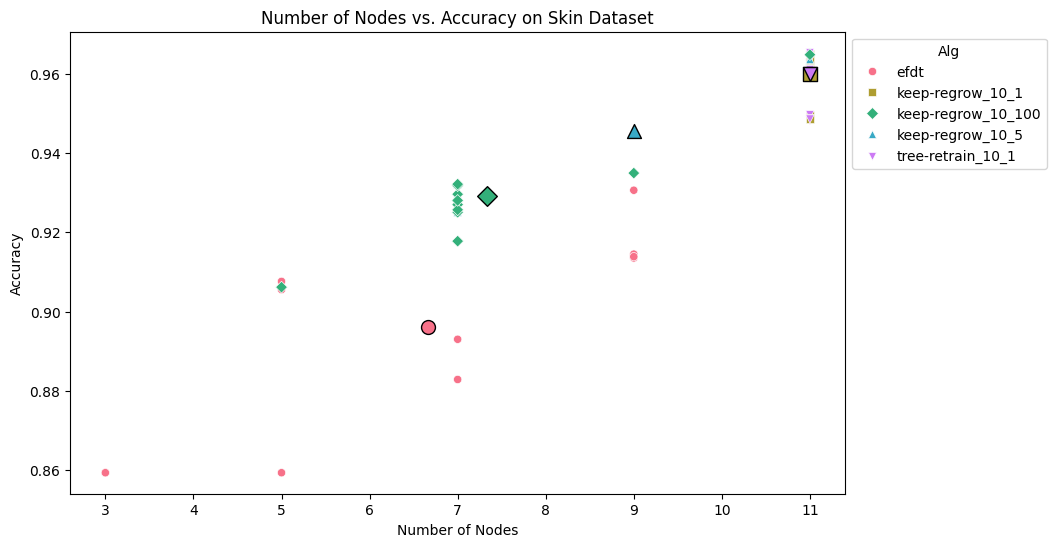

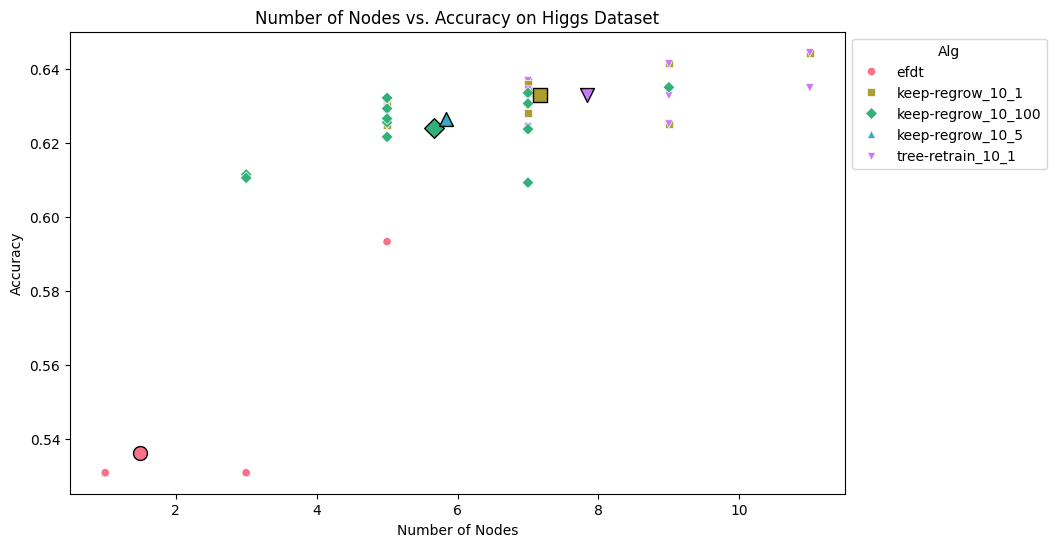

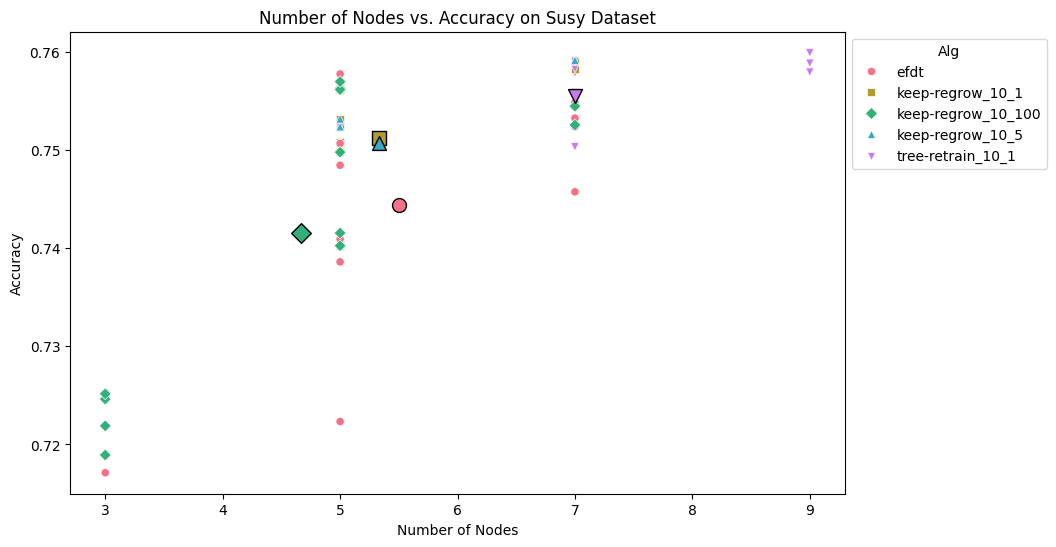

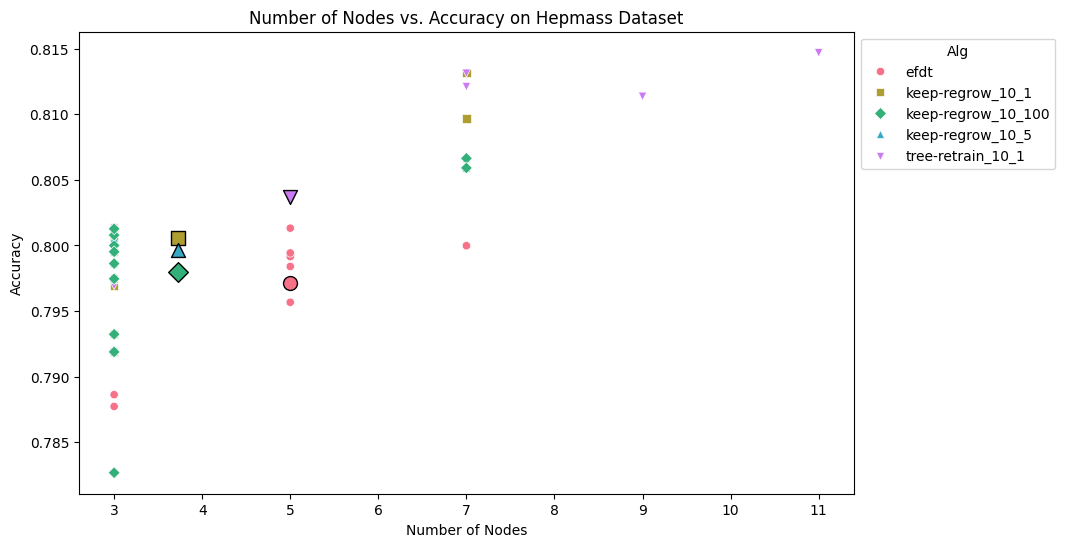

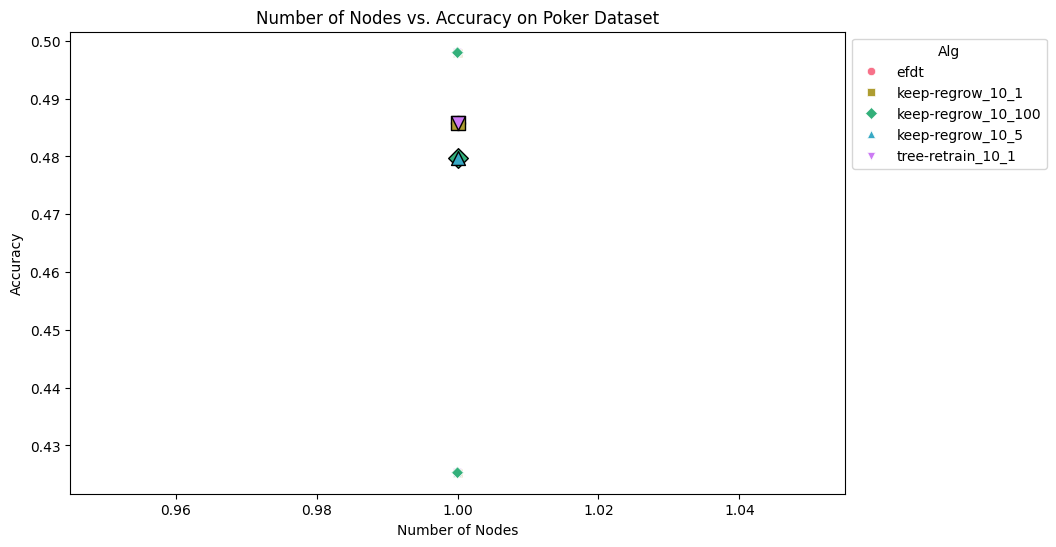

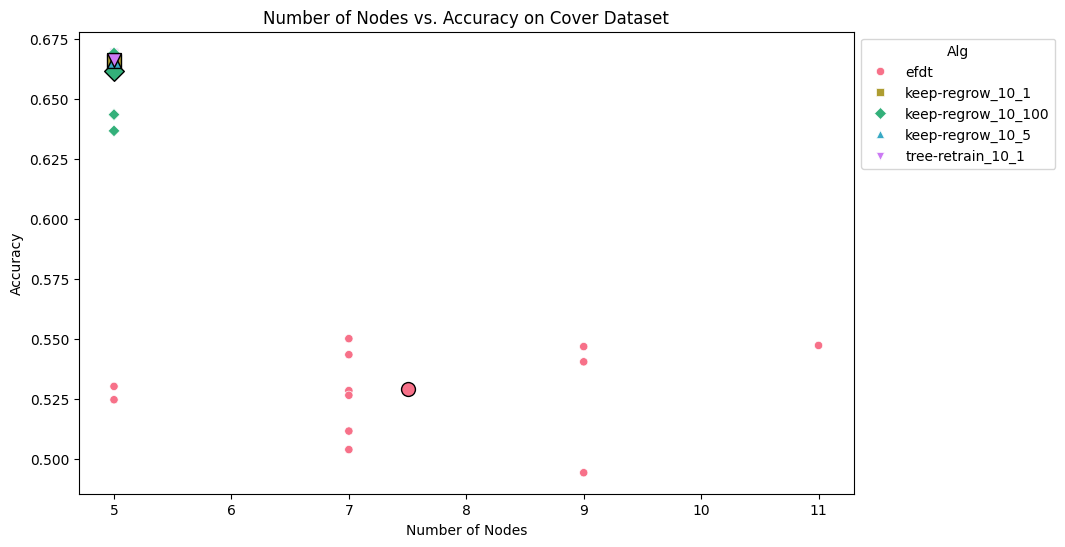

In [12]:
# Get unique datafile names
# unique_datafiles = df['datafile'].unique()
# Use the same order as generated
unique_datafiles = ['Skin', 'Higgs', 'Susy', 'Hepmass', 'Poker', 'Cover']

# Loop through each unique datafile and create a separate plot
for datafile in unique_datafiles:
    # Filter the data for the desired conditions
    filtered_df = df[df['alg'].isin(['efdt', 'keep-regrow_10_1', 'keep-regrow_10_5', 'tree-retrain_10_1', 'keep-regrow_10_100']) &
                     (df['datafile'] == datafile) &
                     (df['batch'] == 2)
                    ]

    # Calculate the group averages
    grouped = filtered_df.groupby('alg').agg({'acc': 'mean', 'nodes': 'mean'}).reset_index()


    # Order of appearance of algorithms in the dataframe
    hue_order = grouped['alg'].unique()

    # Create a custom palette with distinct colors
    custom_palette = sns.color_palette("husl", len(filtered_df['alg'].unique()))

    # Create a custom list of markers for distinct symbols
    markers = ['o', 's', 'D', '^', 'v', '>', '<']
    alg_marker_mapping = {alg: markers[i] for i, alg in enumerate(hue_order)}

    # Create the scatter plot with distinct colors and symbols
    plt.figure(figsize=(10, 6))
    sns.scatterplot(y='acc', x='nodes', hue='alg', style='alg',markers=alg_marker_mapping, palette=custom_palette, data=filtered_df, hue_order=hue_order)
    plt.title(f'Number of Nodes vs. Accuracy on {datafile} Dataset')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of Nodes')
    plt.legend(title='Alg', loc='upper left', bbox_to_anchor=(1, 1))

    # Plot the group averages as symbols
    for index, row in grouped.iterrows():
        plt.scatter(row['nodes'], row['acc'], marker=alg_marker_mapping[row['alg']], s=100, color=custom_palette[index], edgecolor='black', linewidth=1)

    plt.show()

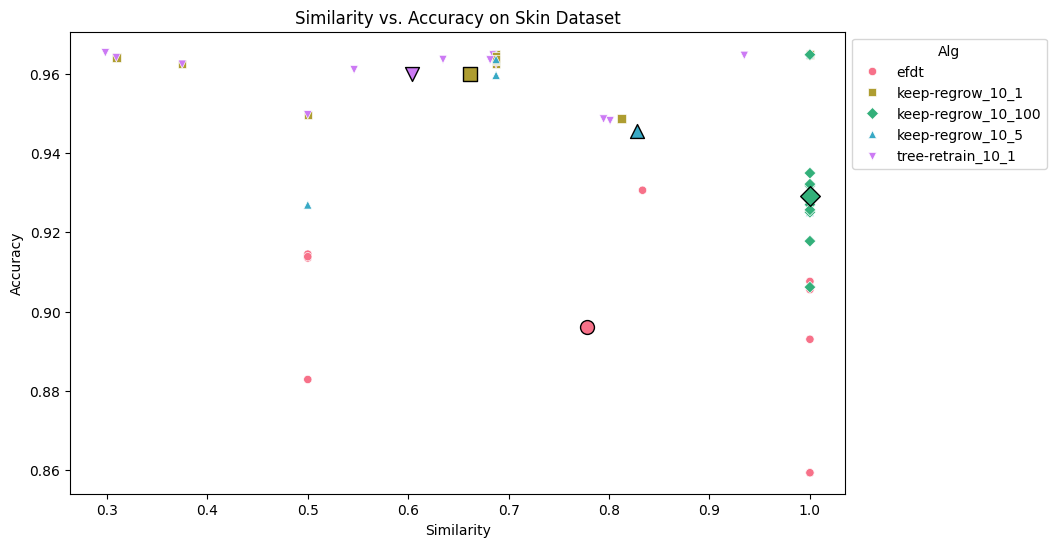

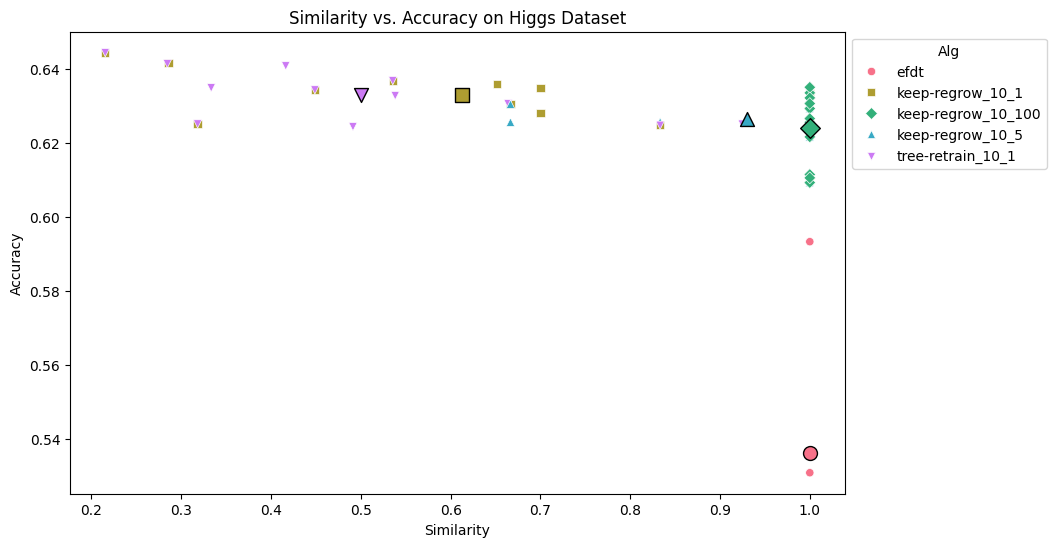

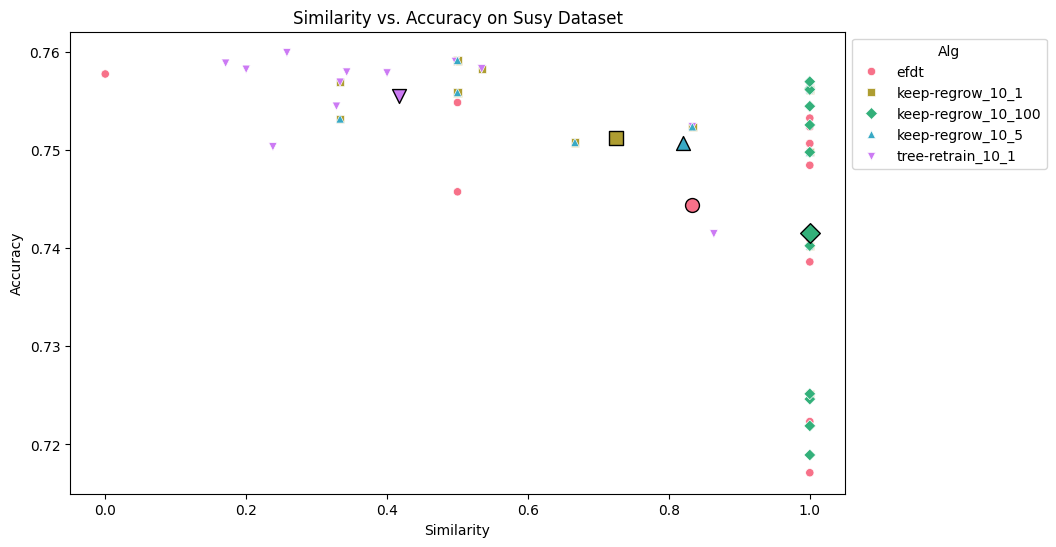

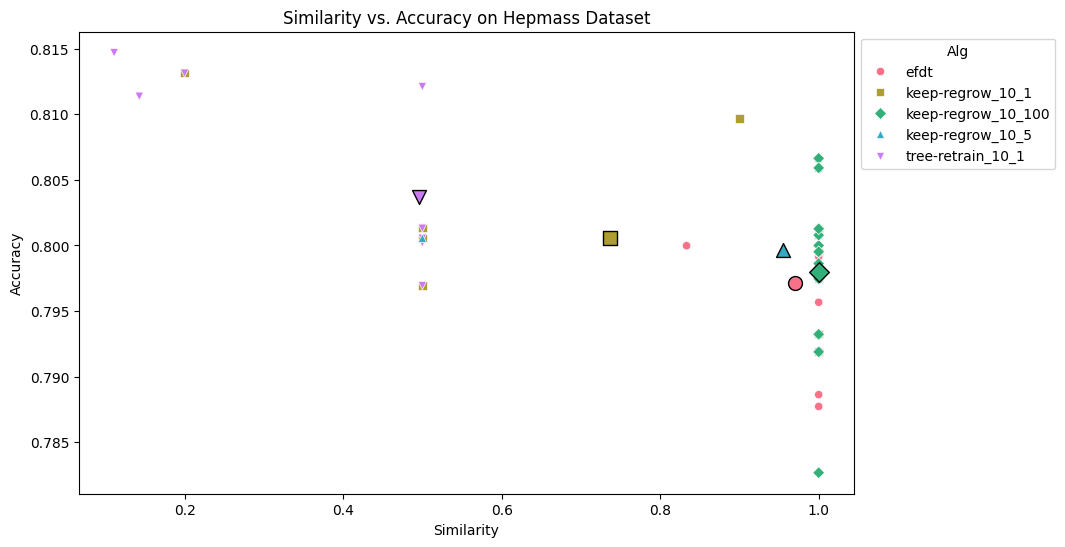

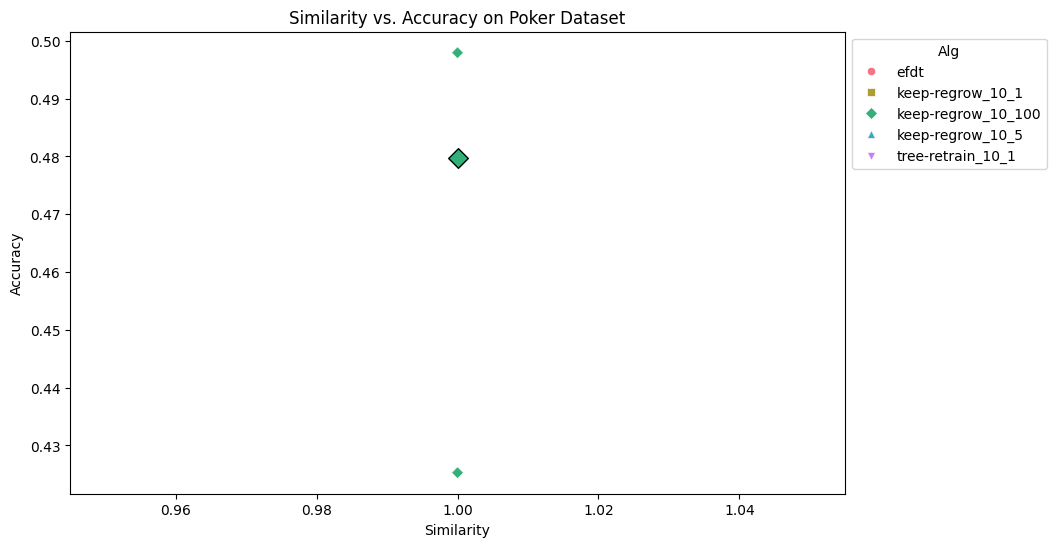

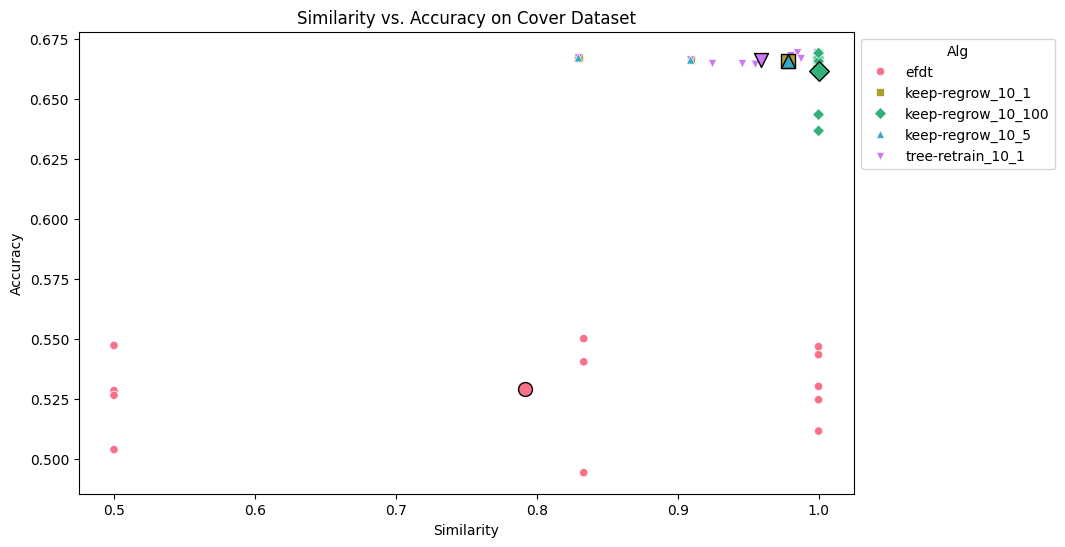

In [13]:
# Get unique datafile names
# unique_datafiles = df['datafile'].unique()
# Use the same order as generated
unique_datafiles = ['Skin', 'Higgs', 'Susy', 'Hepmass', 'Poker', 'Cover']

# Loop through each unique datafile and create a separate plot
for datafile in unique_datafiles:
    # Filter the data for the desired conditions
    filtered_df = df[df['alg'].isin(['efdt', 'keep-regrow_10_1', 'keep-regrow_10_5', 'tree-retrain_10_1', 'keep-regrow_10_100']) &
                     (df['datafile'] == datafile) &
                     (df['batch'] == 2)
                    ]

    # Calculate the group averages
    grouped = filtered_df.groupby('alg').agg({'acc': 'mean', 'similarity': 'mean'}).reset_index()


    # Order of appearance of algorithms in the dataframe
    hue_order = grouped['alg'].unique()

    # Create a custom palette with distinct colors
    custom_palette = sns.color_palette("husl", len(filtered_df['alg'].unique()))

    # Create a custom list of markers for distinct symbols
    markers = ['o', 's', 'D', '^', 'v', '>', '<']
    alg_marker_mapping = {alg: markers[i] for i, alg in enumerate(hue_order)}

    # Create the scatter plot with distinct colors and symbols
    plt.figure(figsize=(10, 6))
    sns.scatterplot(y='acc', x='similarity', hue='alg', style='alg',markers=alg_marker_mapping, palette=custom_palette, data=filtered_df, hue_order=hue_order)
    plt.title(f'Similarity vs. Accuracy on {datafile} Dataset')
    plt.ylabel('Accuracy')
    plt.xlabel('Similarity')
    plt.legend(title='Alg', loc='upper left', bbox_to_anchor=(1, 1))

    # Plot the group averages as symbols
    for index, row in grouped.iterrows():
        plt.scatter(row['similarity'], row['acc'], marker=alg_marker_mapping[row['alg']], s=100, color=custom_palette[index], edgecolor='black', linewidth=1)

    plt.show()